In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
train = pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Skillbox_regression-9\train.csv')
train.tail()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
795,1025,304.8,0.0,99.6,196.0,9.8,959.4,705.2,28,30.12
796,1026,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
797,1027,288.0,192.0,0.0,192.0,0.0,932.0,717.8,28,38.80
798,1028,450.1,50.0,0.0,200.0,3.0,1124.4,613.2,28,39.38
799,1029,362.6,189.0,0.0,164.9,11.6,944.7,755.8,91,79.30


In [3]:
train.isna().sum()

Id                    0
Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  800 non-null    int64  
 1   Cement              800 non-null    float64
 2   Blast Furnace Slag  800 non-null    float64
 3   Fly Ash             800 non-null    float64
 4   Water               800 non-null    float64
 5   Superplasticizer    800 non-null    float64
 6   Coarse Aggregate    800 non-null    float64
 7   Fine Aggregate      800 non-null    float64
 8   Age                 800 non-null    int64  
 9   Strength            800 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 62.6 KB


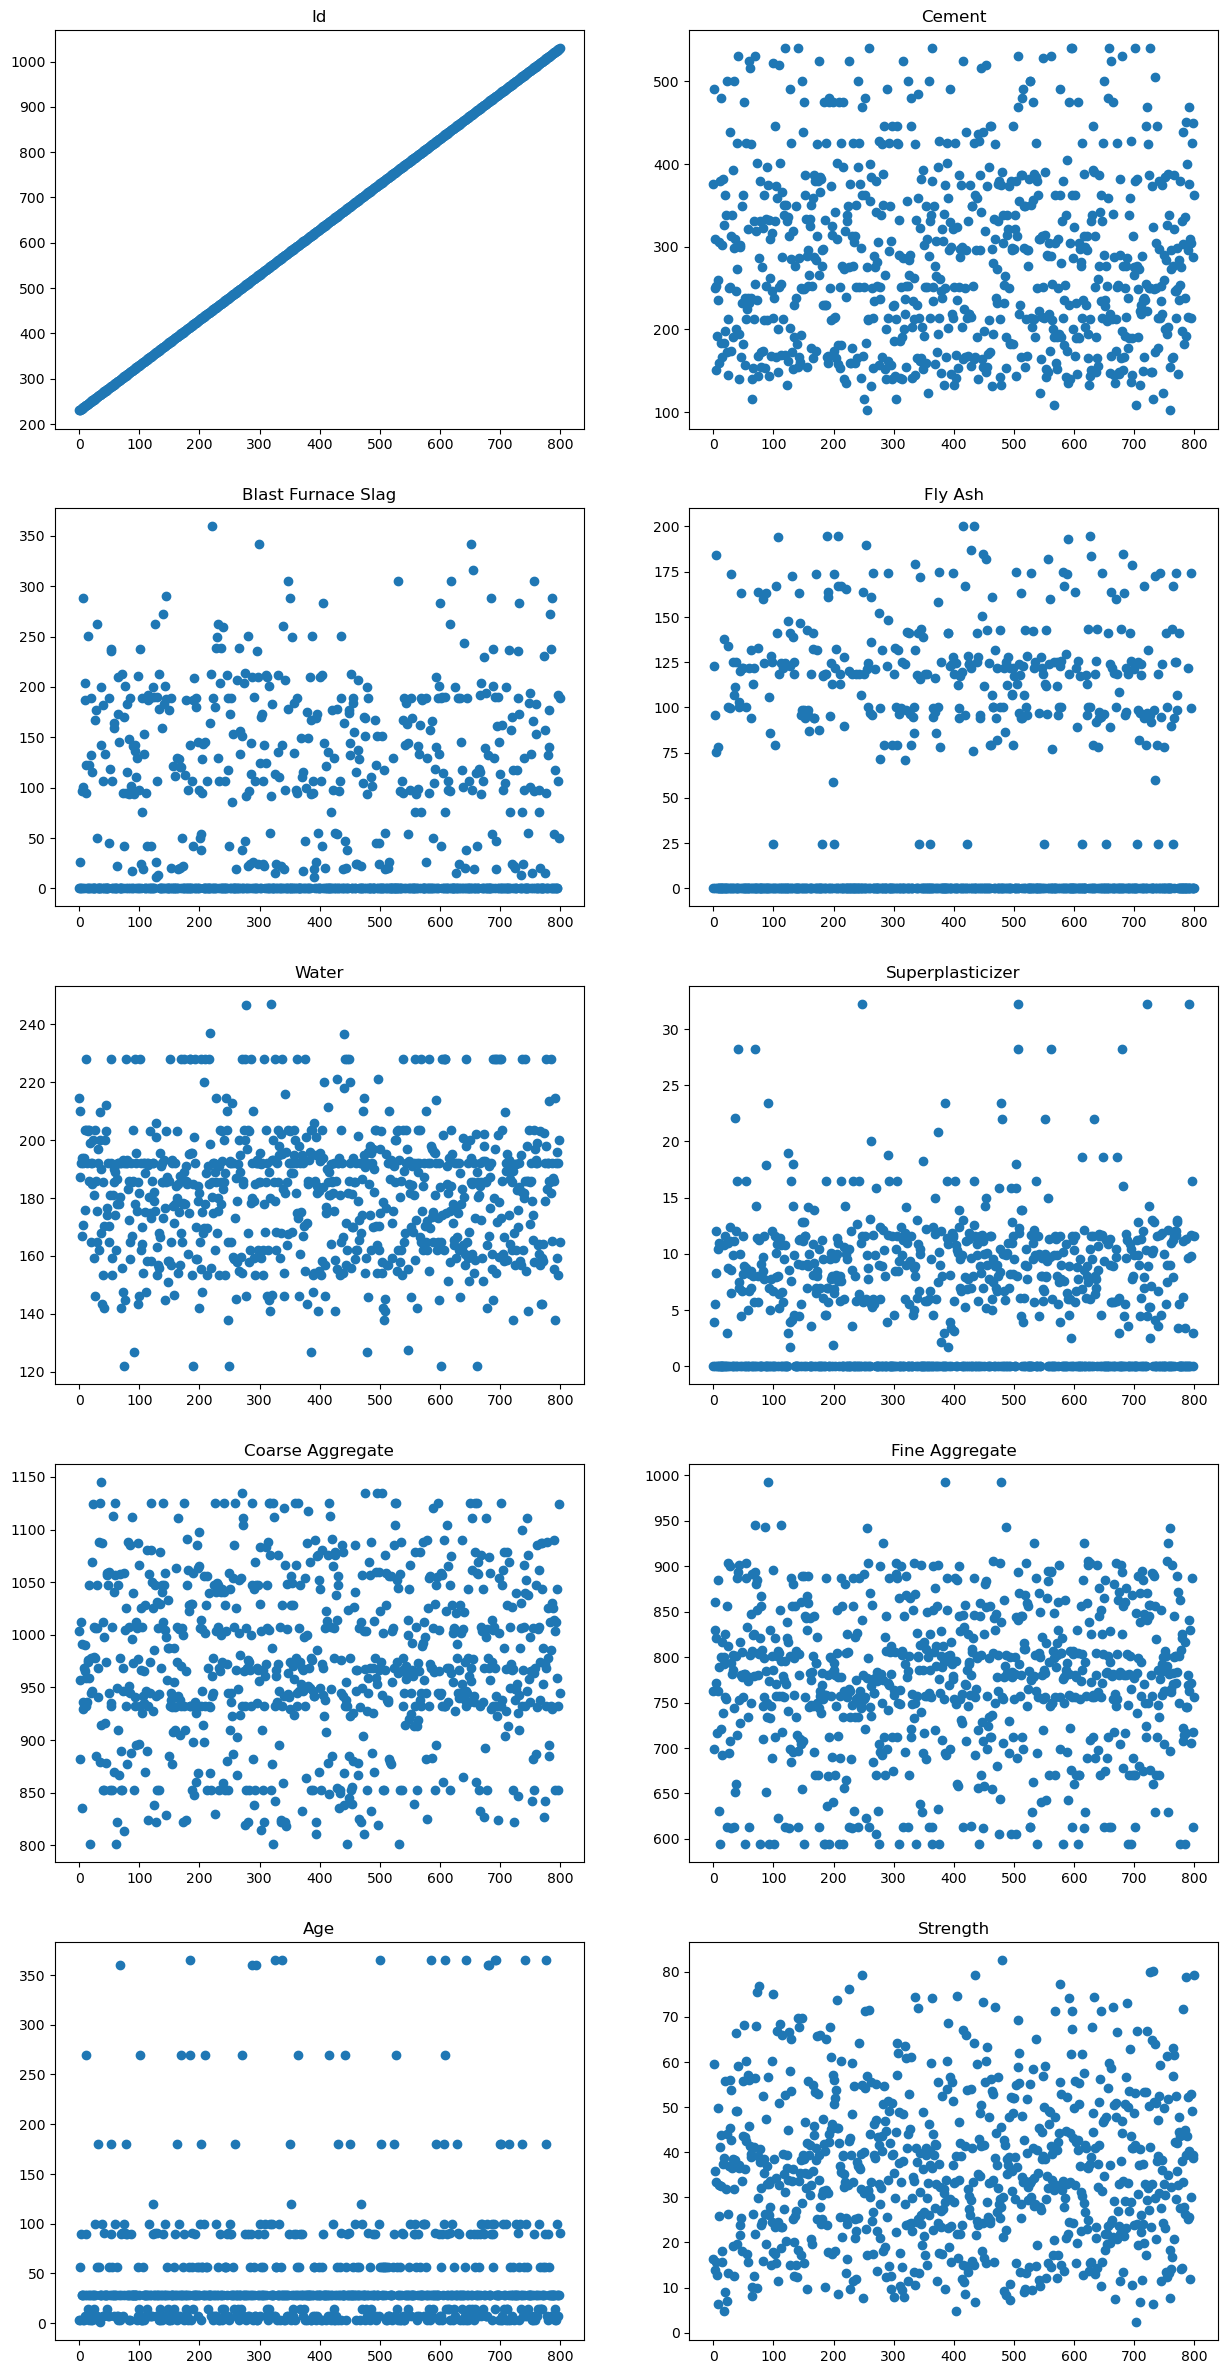

In [8]:
fig, axs = plt.subplots(figsize=(15, 30), nrows=5, ncols=2)
for ax, col in zip(axs.flat, train.columns):
    ax.scatter(train.index, train[col])
    ax.set_title(col)

In [9]:
def quantilecount(dframe, cols: list):

    dframe2 = dframe.copy()

    for col in dframe.drop(columns=cols):

        qMin = dframe[col].quantile(0.25)
        qMax = dframe[col].quantile(0.75)
        iqr = qMax - qMin
        bounds = (qMin - iqr*1.5, iqr*1.5 + qMax)

        dframe2 = dframe2[dframe2[col] >= bounds[0]].copy()
        dframe2 = dframe2[dframe2[col] <= bounds[1]].copy()

    return dframe2.reset_index(drop=True)

In [5]:
train2 = train.copy()
train2['Cement/Water'] = train2['Cement'] / train2['Water']
train2['Water/Age'] = train2['Water'] / train2['Age']
train2['Superplasticizer/Age'] = train2['Superplasticizer'] / train2['Age']
train2['Coarse/Fine'] = train2['Coarse Aggregate'] / train2['Fine Aggregate']
train2.tail()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength,Cement/Water,Water/Age,Superplasticizer/Age,Coarse/Fine
795,1025,304.8,0.0,99.6,196.0,9.8,959.4,705.2,28,30.12,1.555102,7.000000,0.350000,1.360465
796,1026,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20,2.768730,21.928571,2.357143,0.960546
797,1027,288.0,192.0,0.0,192.0,0.0,932.0,717.8,28,38.80,1.500000,6.857143,0.000000,1.298412
798,1028,450.1,50.0,0.0,200.0,3.0,1124.4,613.2,28,39.38,2.250500,7.142857,0.107143,1.833659
799,1029,362.6,189.0,0.0,164.9,11.6,944.7,755.8,91,79.30,2.198908,1.812088,0.127473,1.249934


In [7]:
def inf_emp_val(dframe):
    arr = []
    for col, n in zip(dframe, range(len(dframe))):
        temp = dframe.isnull()[col].sum()
        if temp != 0:
            print(f'{n}: {temp} {col}')
    print('Done')

    arr = []
    for col, n in zip(dframe, range(len(dframe))):
        temp = dframe[col].isin([np.inf, -np.inf]).sum()
        if temp != 0:
            print(f'{n}: {temp} {col}')
    print('Done')

In [8]:
inf_emp_val(train2)

Done
Done


In [9]:
train2_scaler = StandardScaler().fit_transform(train2.drop(columns=['Id', 'Strength']))
train3 = pd.concat([train2[['Id', 'Strength']],
                   pd.DataFrame(data=train2_scaler, columns=train2.drop(columns=['Id', 'Strength']).columns)], axis=1).reset_index(drop=True)
train3.tail()

,Id,Strength,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Cement/Water,Water/Age,Superplasticizer/Age,Coarse/Fine
795,1025,30.12,0.182979,-0.835666,0.737991,0.648728,0.612058,-0.183151,-0.828618,-0.291139,-0.067781,-0.401596,-0.137556,0.436895
796,1026,49.20,1.317427,0.393333,-0.828338,-1.306051,1.727766,-1.546899,1.424613,-0.619689,1.786148,0.365128,1.744010,-1.677135
797,1027,38.80,0.024421,1.384163,-0.828338,0.464749,-1.019874,-0.531396,-0.672540,-0.291139,-0.151954,-0.408933,-0.465658,0.108873
798,1028,39.38,1.554320,-0.257585,-0.828338,0.832707,-0.520303,1.913945,-1.968241,-0.291139,0.994504,-0.394258,-0.365219,2.938266
799,1029,79.30,0.728495,1.349478,-0.828338,-0.781710,0.911800,-0.369983,-0.201826,0.694513,0.915693,-0.668044,-0.346161,-0.147388


In [109]:
X = train3.drop(columns=['Id', 'Strength'])
Y = train3.Strength

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=42)

# DecisionTreeRegressor----------------------------------------------------------------------

In [11]:
dtr = DecisionTreeRegressor(max_depth=50, random_state=42).fit(xtrain, ytrain)
predDTR = dtr.predict(xtest)
root_mean_squared_error(ytest, predDTR)

6.6887440587402756

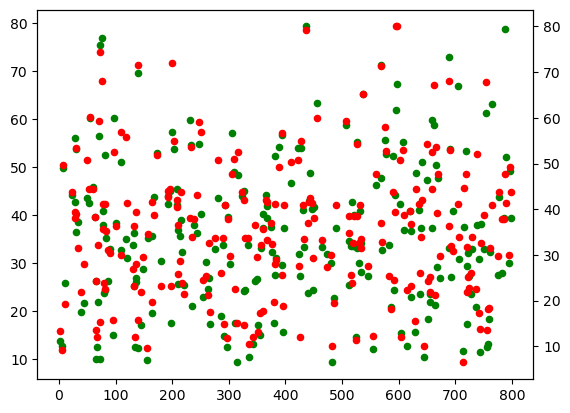

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(xtest.index, ytest, c='g', s=20)
ax2.scatter(xtest.index, predDTR, c='r', s=20);

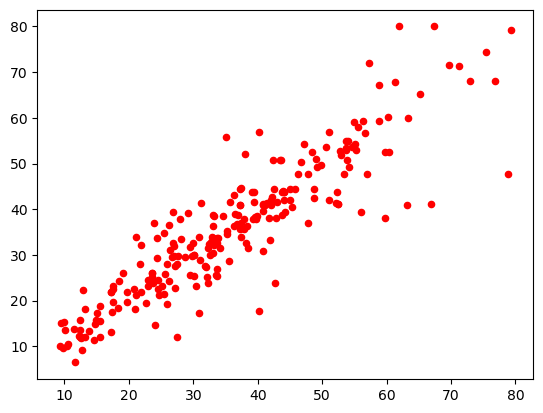

In [13]:
plt.scatter(ytest, predDTR, c='r', s=20);

# NN------------------------------------------------------------------------------------------------------

In [14]:
class Set(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.to_numpy().astype('float32'))
        self.y = torch.tensor(y.to_numpy().astype('float32'))
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.x.shape[0]

In [15]:
traindata = Set(xtrain, ytrain)
trainloader = DataLoader(dataset=traindata, batch_size=80, shuffle=True)

In [16]:
for batch, [x, y] in enumerate(trainloader, 1):
    print(batch, x.shape, y.shape)

1 torch.Size([80, 12]) torch.Size([80])
2 torch.Size([80, 12]) torch.Size([80])
3 torch.Size([80, 12]) torch.Size([80])
4 torch.Size([80, 12]) torch.Size([80])
5 torch.Size([80, 12]) torch.Size([80])
6 torch.Size([80, 12]) torch.Size([80])
7 torch.Size([80, 12]) torch.Size([80])


In [110]:
class Net(nn.Module):
    def __init__(self, one, two, three, four, five, six, seven, eight, nine):
        super().__init__()
        self.flatten = nn.Flatten()
        self.seq = nn.Sequential(
                                    # 80
        nn.Linear(one, two), # 128
        nn.Tanh(),
        nn.Linear(two, three), # 128
        nn.ReLU(),
        nn.Linear(three, four), # 1024
        nn.LeakyReLU(),
        nn.Linear(four, five), # 2048
        nn.ReLU(),
        nn.Linear(five, six), # 512
        nn.LeakyReLU(),
        nn.Linear(six, seven), # 4
        nn.ReLU(),
        nn.Linear(seven, eight), # 2
        nn.ReLU(),
        nn.Linear(eight, nine) # 1
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.seq(x)
        return x

In [101]:
model = Net(xtrain.shape[1], 128, 128, 1024, 2048, 512, 4, 2, 1)
print(model)

lossfn = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (seq): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=1024, out_features=2048, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=512, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=512, out_features=4, bias=True)
    (11): ReLU()
    (12): Linear(in_features=4, out_features=2, bias=True)
    (13): ReLU()
    (14): Linear(in_features=2, out_features=1, bias=True)
  )
)


In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

In [102]:
losslist1 = []
losslist2 = []

for batch in range(800):
    for x, y in trainloader:
        
        pred = model(x)
        loss = lossfn(pred, y.unsqueeze(-1))        
        loss.backward()
        
        optim.step()
        optim.zero_grad()
        
        losslist1.append(loss.item())
        
    losslist2.append(np.array(losslist1).mean())
    losslist1 = []

Mean:  13.325339941903952 

Median:  3.2505356848239897 

Min:  1.1417356491088868 



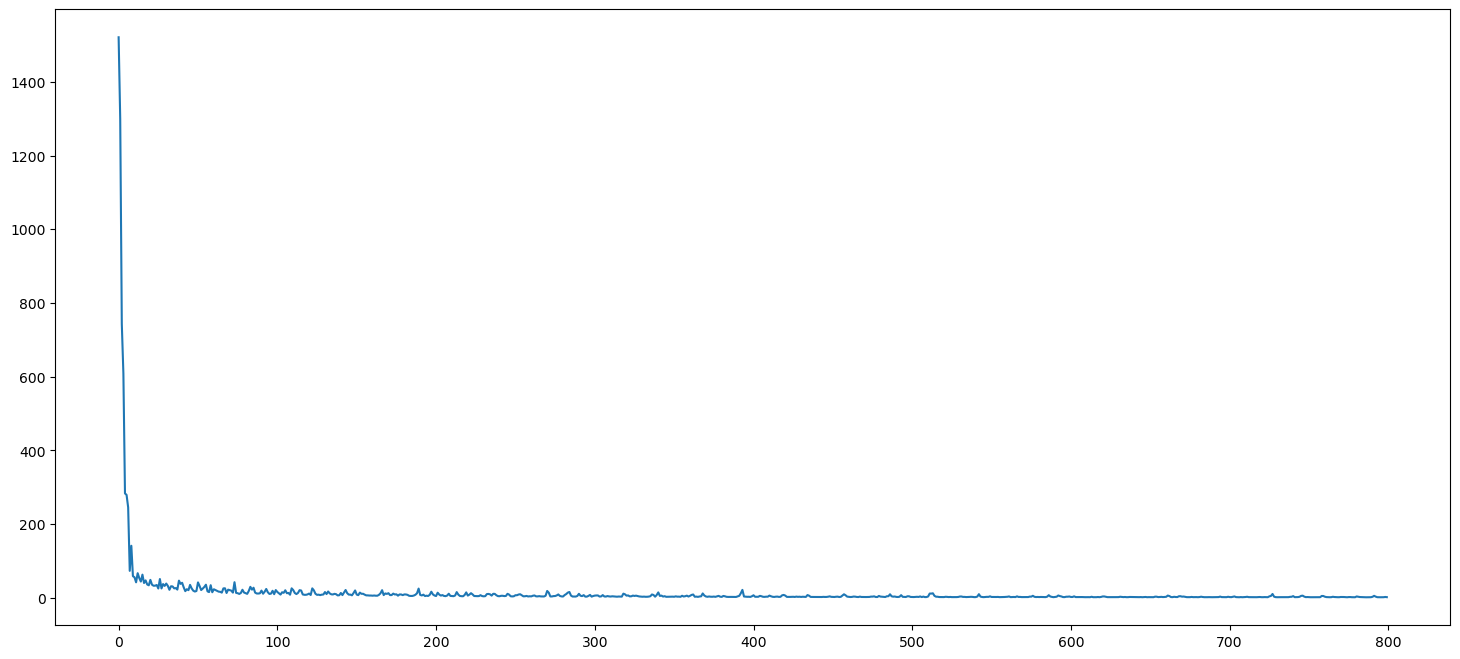

In [103]:
print('Mean: ', np.array(losslist2).mean(), '\n')
print('Median: ', pd.Series(losslist2).median(), '\n')
print('Min: ', min(losslist2), '\n')

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(losslist2)
plt.show()

In [104]:
with torch.no_grad():
    predNN = model(torch.tensor(xtest.to_numpy().astype('float32')))

print('RMSE: ', root_mean_squared_error(ytest, predNN), '\n')
print('MSE: ', mean_squared_error(ytest, predNN))

RMSE:  0.9736464487509088 

MSE:  0.947987407165256


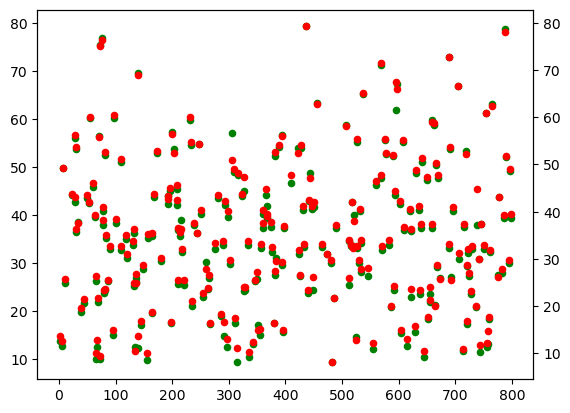

In [105]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(xtest.index, ytest, c='g', s=20)
ax2.scatter(xtest.index, predNN, c='r', s=20);

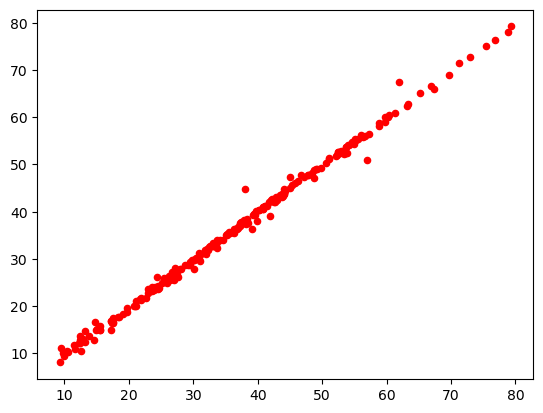

In [106]:
plt.scatter(ytest, predNN, c='r', s=20);

# Final test modeling-----------------------------------------------------------------------------------

Mean:  11.37166584785945 

Median:  2.5162680089473723 

Min:  1.034358476102352 



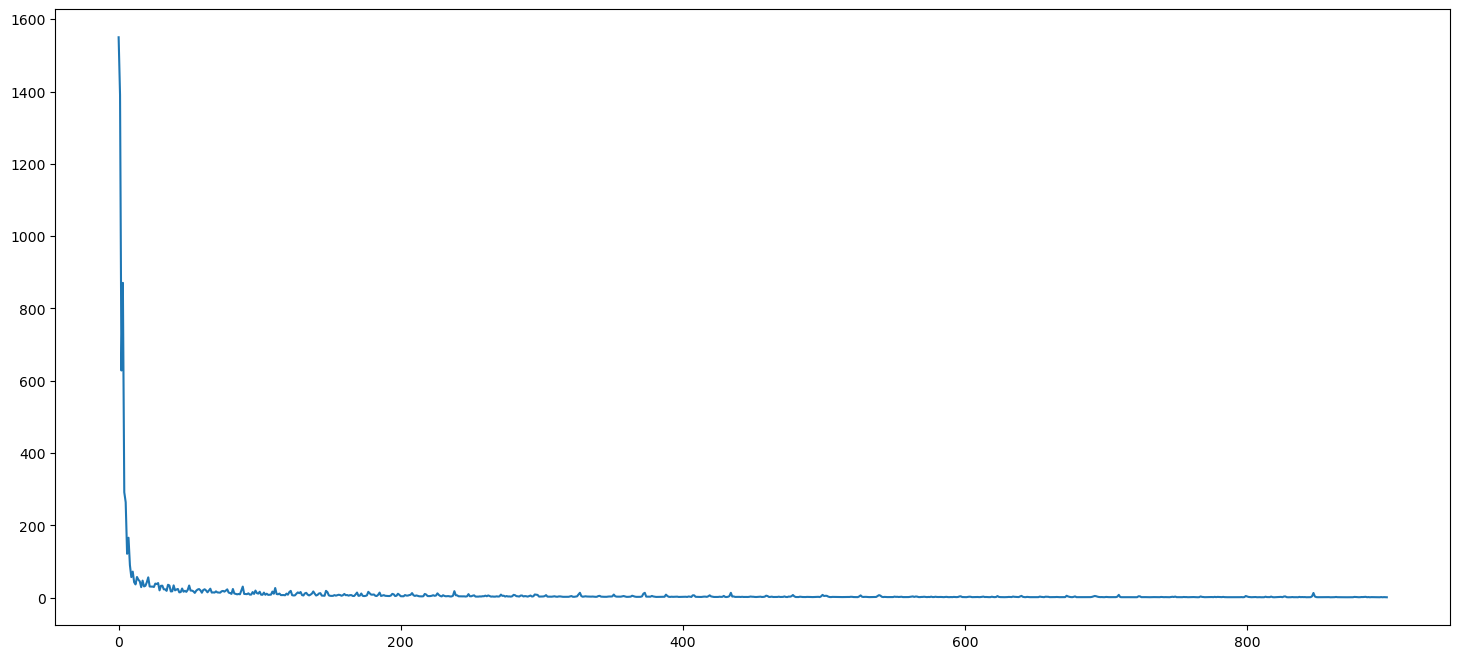

In [112]:
model = Net(xtrain.shape[1], 128, 128, 1024, 2048, 512, 4, 2, 1)

lossfn = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001)

traindata = Set(X, Y)
trainloader = DataLoader(dataset=traindata, batch_size=80, shuffle=True)

losslist1 = []
losslist2 = []

for batch in range(900):
    for x, y in trainloader:
        
        pred = model(x)
        loss = lossfn(pred, y.unsqueeze(-1))        
        loss.backward()
        
        optim.step()
        optim.zero_grad()
        
        losslist1.append(loss.item())
        
    losslist2.append(np.array(losslist1).mean())
    losslist1 = []
    
    
print('Mean: ', np.array(losslist2).mean(), '\n')
print('Median: ', pd.Series(losslist2).median(), '\n')
print('Min: ', min(losslist2), '\n')

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(losslist2)
plt.show()

In [113]:
test = pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Skillbox_regression-9\test.csv')
test.tail()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
225,225,213.7,0.0,174.7,154.8,10.2,1053.5,776.4,100
226,226,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3
227,227,401.8,94.7,0.0,147.4,11.4,946.8,852.1,3
228,228,318.0,0.0,126.0,210.0,6.0,861.0,737.0,28
229,229,255.0,0.0,0.0,192.0,0.0,889.8,945.0,3


In [114]:
test2 = test.copy()
test2['Cement/Water'] = test['Cement'] / test['Water']
test2['Water/Age'] = test['Water'] / test['Age']
test2['Superplasticizer/Age'] = test['Superplasticizer'] / test['Age']
test2['Coarse/Fine'] = test2['Coarse Aggregate'] / test2['Fine Aggregate']
test2.tail()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Cement/Water,Water/Age,Superplasticizer/Age,Coarse/Fine
225,225,213.7,0.0,174.7,154.8,10.2,1053.5,776.4,100,1.380491,1.548000,0.102000,1.356904
226,226,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3,0.531250,64.000000,0.000000,0.941614
227,227,401.8,94.7,0.0,147.4,11.4,946.8,852.1,3,2.725916,49.133333,3.800000,1.111137
228,228,318.0,0.0,126.0,210.0,6.0,861.0,737.0,28,1.514286,7.500000,0.214286,1.168250
229,229,255.0,0.0,0.0,192.0,0.0,889.8,945.0,3,1.328125,64.000000,0.000000,0.941587


In [115]:
inf_emp_val(test2)

Done
Done


In [116]:
test2_scaler = StandardScaler().fit_transform(test2.drop(columns=['Id']))
test3 = pd.concat([test2[['Id']],
                   pd.DataFrame(data=test2_scaler, columns=test2.drop(columns=['Id']).columns)], axis=1).reset_index(drop=True)


test4 = test3.drop(columns=['Id'])


with torch.no_grad():
    predNNtest = model(torch.tensor(test4.to_numpy().astype('float32')))

In [117]:
predicted_Strength = pd.DataFrame(data={'Id': test3['Id'], 'Strength': predNNtest.squeeze()})
predicted_Strength.to_csv('Rver20.csv', index=False)

# Tests

In [ ]:
model1 = Net(8, 512, 1024, 512, 2, 1)

In [77]:
for param in model1.parameters():
    print(param.shape)

NameError: name 'model1' is not defined

In [83]:
import torch.nn.init as init
init.xavier_uniform_(Line.weight)
init.zeros_(Line.bias)

Line = nn.Linear(2, 1, bias=True)

Line(torch.tensor([1,1], dtype=torch.float32))

print('weight: ', Line.weight)
print('bias: ', Line.bias)

weight:  Parameter containing:
tensor([[-0.0410,  0.2112]], requires_grad=True)
bias:  Parameter containing:
tensor([0.0507], requires_grad=True)
